## **量化投资分析：基于茅指数的均值回归策略**

### **1. 项目介绍**

本项目聚焦于中国A股市场的 "核心资产" 投资策略，通过构建和回测基于 "茅指数" 的均值回归模型，探索量化投资在龙头股组合中的应用。项目将实现数据获取与处理、策略回测、绩效评估和可视化展示的完整流程。本项目主要研究所选成分股在2025年上半年（2025.1.1-2025.6.30）期间的表现与投资策略，读者可在此基础上进行延伸探究。

> **茅指数：** 主要指在消费、医药、科技制造等领域具有较强成长性和技术实力的一些A股龙头企业。茅指数并不是一个标准的概念，不同机构统计的企业可能有所出入，但总体来说较为一致。以Wind中的茅指数为例，截至2025年7月，共包含42家公司。本项目选取以下10只代表性股票作为成分股。

|股票代码|简称|A股市值（亿元）|申万行业二级分类|
|:----:|:----:|:----:|:----:|
|600519.SH|Kweichow Moutai|18130|饮料制造|
|600036.SH|China Merchants Bank|9252|银行|
|600900.SH|China Yangtze Power|7223|电力|
|600276.SH|Hengrui Medicine|3700|化学制药|
|600309.SH|Wanhua|1876|化工新材料|
|600887.SH|YiLi Group|1783|食品加工制造|
|600690.SH|Haier|1629|白色家电|
|600436.SH|Pien Tze Huang|1198|中药|
|600585.SH|Conch Cement|988|建筑材料|
|600763.SH|Zhongyan Textile|190|医疗服务|

数据来源：Choice

> **均值回归策略(Mean Reversion Strategy)：** 量化金融中的经典策略。该策略基于统计学原理，认为资产价格在偏离其历史均值后，最终会回归到平均水平。因此，通过识别这些偏离机会，可以在价格回归时获得收益。

### **2. 项目环境搭建**

以下展示使用Conda工具搭建项目环境的过程：

```bash
# Recreate environment from file
conda env create -f environment.yml

# Activate environment
conda activate algovault

# Verify installation (optional)
conda list
```

### **3. 基于茅指数的均值回归策略**

**3.1 数据获取与处理**

本项目数据来源于Tushare金融数据平台（https://tushare.pro/ ），需要用户自行注册账户并获取一定积分后方可使用。如无法成功获取，本项目提供了选取的10只成分股2021.1.4-2021.4.30的部分数据供读者使用。

如何获取Tushare API Token：
1. 注册Tushare账号：https://tushare.pro/
2. 登录后在 "个人中心" 获取接口Token
3. 创建.env文件，在文件中写入你的Token：TUSHARE_API_KEY = "你的Token"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 设置Tushare API Token
import tushare as ts
import os
from dotenv import load_dotenv

load_dotenv()
TUSHARE_API_KEY = os.environ.get("TUSHARE_API_KEY")

读取10只成分股和沪深300的相关数据，本项目将会使用收盘价$closePrice$、流通市值$negMarketValue$、涨跌幅$chgPct$三个字段。

In [4]:
from algovault import init_tushare, get_stock_data, get_hs300_data, set_stock_mapping

# 股票代码与名称映射
STOCK_MAPPING = {
    '600519': 'Kweichow Moutai',
    '600036': 'China Merchants Bank',
    '600900': 'China Yangtze Power', 
    '600276': 'Hengrui Medicine',
    '600309': 'Wanhua',
    '600887': 'YiLi Group',
    '600690': 'Haier',
    '600436': 'Pien Tze Huang',
    '600585': 'Conch Cement',
    '600763': 'Zhongyan Textile'  
}

set_stock_mapping(STOCK_MAPPING)

# 参数设置
start_date = '20250101'
end_date = '20250630'
tickers = list(STOCK_MAPPING.keys())
        
# 初始化API
pro = init_tushare(TUSHARE_API_KEY)

# 获取数据
stock_data = get_stock_data(pro, STOCK_MAPPING, start_date, end_date)
hs300_data = get_hs300_data(pro, start_date, end_date)

Tushare API连接成功
成功获取 600519 (Kweichow Moutai) 数据
成功获取 600036 (China Merchants Bank) 数据
成功获取 600900 (China Yangtze Power) 数据
成功获取 600276 (Hengrui Medicine) 数据
成功获取 600309 (Wanhua) 数据
成功获取 600887 (YiLi Group) 数据
成功获取 600690 (Haier) 数据
成功获取 600436 (Pien Tze Huang) 数据
成功获取 600585 (Conch Cement) 数据
成功获取 600763 (Zhongyan Textile) 数据
成功获取HS300指数数据


**3.2 策略回测**

- *捏合自定义"茅指数"* \
以流通市值$negMarketValue$为权重捏合这10只股票，形成自定义的"茅指数"：\
假设$mktvalue_k^t$为第t天、第k只股票的流通市值；$r_k^t$为第t天、第k只股票的收益率（以涨跌幅$chgPct$表示）。\
*第t天总市值：* $$total \_ mktvalue_t = \sum_{k=1}^{10} mktvalue_k^t$$ 
*第t天、第k只股票占茅指数的权重：* $$weight_k^t = mktvalue_k^t / total \_ mktvalue_t$$ 
*茅指数每日收益率：* $$mao\_ r_t = \sum_{k=1}^{10} weight_k^t \times r_k^t$$

- *均值回归策略回测* \
计算当日个股收盘价的5日均值：$\text{MA5}$ \
计算当日个股收盘价到5日均值的偏离程度：$ratio = (closePrice-\text{MA5})/\text{MA5}$ \
根据当日所有个股的$ratio$，挑出$ratio$为负的个股，第二天等权持仓 \
*解释：$ratio$为负时，说明当前个股价格低于$\text{MA5}$，具有回归均值的趋势，价格上涨的可能越大。*\
根据每日的持仓个股和个股收益率，计算每日的策略收益率 \
根据策略、茅指数和沪深300（作为市场基准）的每日收益率，分别计算每日净值，便于后续进行绩效评估 \
为方便检查，分别输出策略、茅指数和沪深300最后一天的净值

$PS$：
1. 在计算5日均值时，前4日会产生Nan，当$ratio$为Nan值时，默认持有该股票； 
2. 由于我们用当天数据预测第二天持仓，所以我们规定首个交易日（2025/1/1）等权持有10只股票。 

> *净值计算公式：* 其中$r_i$为第i天的收益率，$Nav_t$为第t天的净值 $$Nav_t = \prod_{i=1}^{t} (1+r_i)$$ 

In [6]:
from algovault import calculate_mao_index, mean_reversion_strategy

# 计算茅指数收益率
mao_returns = calculate_mao_index(stock_data)
    
# 运行策略
strategy_nav, mao_nav, hs300_nav, positions, returns = mean_reversion_strategy(
    stock_data, mao_returns, hs300_data
)

# 输出最后一天净值以检查策略运行情况
print("最后一天净值：")
print(f"均值回归策略净值：{strategy_nav.iloc[-1]:.2f}")
print(f"茅指数净值：{mao_nav.iloc[-1]:.2f}")
print(f"沪深300净值：{hs300_nav.iloc[-1]:.2f}")

最后一天净值：
均值回归策略净值：1.10
茅指数净值：1.02
沪深300净值：1.00


**3.3 绩效评估**

以下使用累计收益率、年化收益率、最大回撤、夏普比率、卡玛比率等作为评估策略回测结果的主要指标。假设一年交易日为252天。
- *累计收益率：* $$\text{Cumulative Return} = \left(\frac{\text{Final Value}}{\text{Initial Value}} - 1\right) \times 100 \% $$
- *年化收益率：* $$\text{Annualized Return} = \left(1 + \text{Cumulative Return}\right)^{\frac{252}{\text{Days}}} - 1 $$
- *最大回撤：* $$\text{Drawdown}_t = \frac{\text{Nav}_t}{\max(\text{Nav}_1, \text{Nav}_2, ..., \text{Nav}_t)} - 1$$ $$\text{Max Drawdown} = \min(\text{Drawdown}_t) \times 100 \% $$
- *夏普比率：* 其中，假设年无风险利率$r_f = 1 \%$，$R_f$为日无风险利率，$R_p$为每日收益率，$\sigma_{(R_p - R_f)}$为收益波动率标准差 $$R_f = (1 + r_f)^{\frac{1}{252}} - 1$$ $$\text{Sharpe Ratio} = \sqrt{252} \times \frac{E[R_p - R_f]}{\sigma_{(R_p - R_f)}}$$
- *卡玛比率：* $$\text{Calmar Ratio} = \frac{\text{Annualized Return}}{|\text{Max Drawdown}|}$$

In [9]:
from algovault import evaluate_strategy

# 评估策略
performance = evaluate_strategy(strategy_nav, mao_nav, hs300_nav)

==== 策略绩效评估 ====
累计收益率: 策略 10.16% | 茅指数 1.66% | HS300 0.03%
年化收益率: 策略 23.17% | 茅指数 3.60% | HS300 0.06%
最大回撤: 策略 -7.19% | 茅指数 -6.70% | HS300 -10.49%
夏普比率: 策略 1.36 | 茅指数 0.35 | HS300 0.43
卡玛比率: 策略 3.22 | 茅指数 0.54 | HS300 0.01


**3.4 可视化展示**

以下通过三个维度的图表来全面展示策略效果：
- *净值曲线对比图：* 对比策略与基准指数（茅指数、沪深300）的收益曲线，并比较不同策略在整个回测期间的收益情况。
- *持仓状态变化图：* 通过子图形式展示策略中每只成分股的持仓状态变化，每个子图对应一只股票，以时间轴为横轴，持仓状态为纵轴（股票持有期间持仓状态为1，不持有为0），帮助分析策略的调仓频率和持仓集中度。
- *价格与技术指标图：* 选取部分代表性股票，绘制其收盘价与5日移动平均线（MA5）的对比图。当股票价格低于MA5时（ratio < 0），策略会在下一个交易日买入该股票，通过高亮区域标记股票持有期。

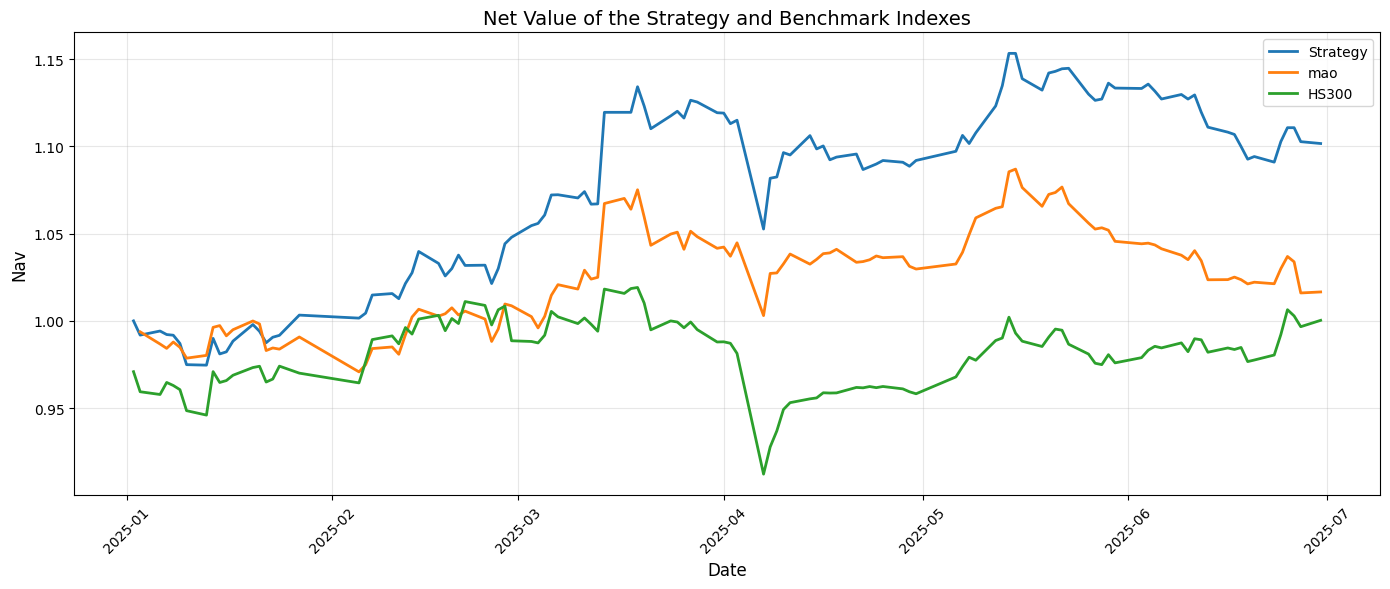

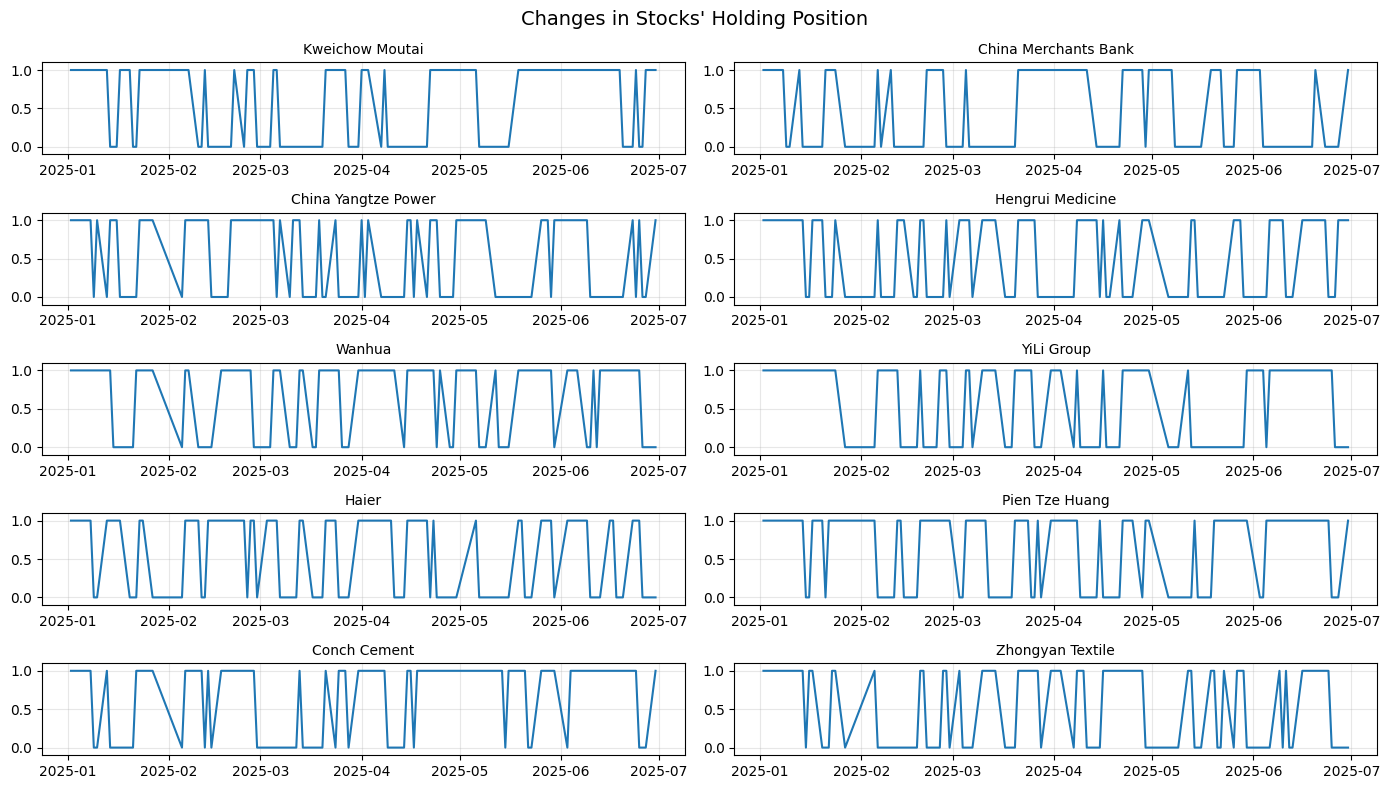

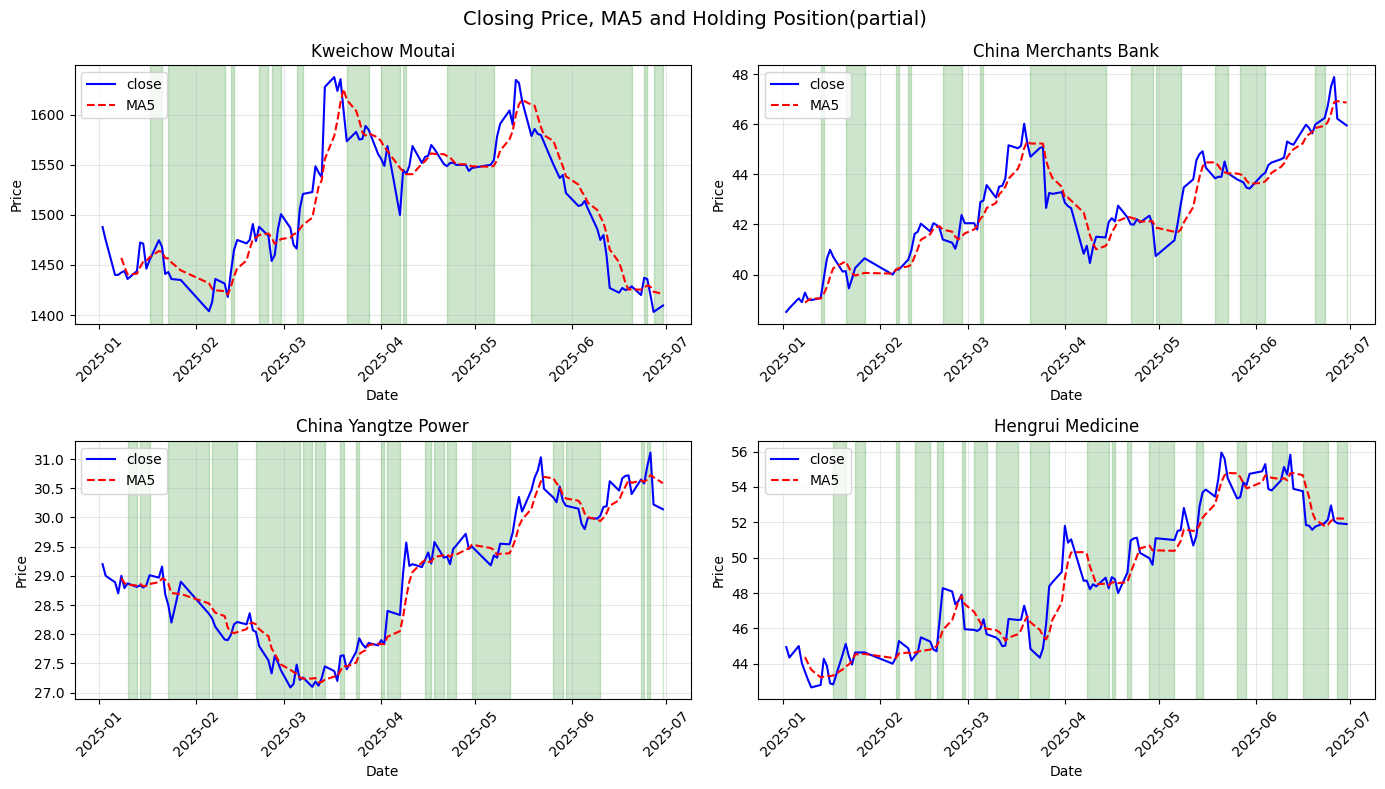

In [10]:
# 可视化函数
def visualize_results(strategy_nav, mao_nav, hs300_nav, positions, stock_data):
    """可视化策略结果"""
    # 1. 绘制净值曲线对比
    plt.figure(figsize=(14, 6))
    plt.plot(strategy_nav.index, strategy_nav, label='Strategy', linewidth=2)
    plt.plot(mao_nav.index, mao_nav, label='mao', linewidth=2)
    plt.plot(hs300_nav.index, hs300_nav, label='HS300', linewidth=2)
    
    plt.title('Net Value of the Strategy and Benchmark Indexes', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Nav', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. 绘制股票持仓变化
    plt.figure(figsize=(14, 8))
    for i, ticker in enumerate(positions.columns):
        plt.subplot(5, 2, i+1)
        plt.plot(positions.index, positions[ticker], label=f'{ticker} ({STOCK_MAPPING[ticker]})')
        plt.title(STOCK_MAPPING[ticker], fontsize=10)
        plt.ylim(-0.1, 1.1)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
    plt.suptitle('Changes in Stocks\' Holding Position', fontsize=14)
    plt.tight_layout()  # 调整布局，避免标题重叠
    plt.show()
    
    # 3. 绘制股票收盘价与MA5
    target_tickers = ['600519', '600036', '600900', '600276']  # 选择部分股票展示
    plt.figure(figsize=(14, 8))
    
    for i, ticker in enumerate(target_tickers):
        df = stock_data[ticker]
        plt.subplot(2, 2, i+1)
        
        # 绘制收盘价和MA5
        plt.plot(df.index, df['closePrice'], 'b-', label='close')
        plt.plot(df.index, df['closePrice'].rolling(window=5).mean(), 'r--', label='MA5')
        
        # 标记持仓状态
        pos = positions[ticker].reindex(df.index)
        pos = pos.fillna(0)
        
        # 持仓期间背景高亮
        start = None
        for j in range(1, len(pos)):
            if pos.iloc[j] == 1 and pos.iloc[j-1] == 0:
                start = pos.index[j]  # 记录持仓开始
            if pos.iloc[j] == 0 and pos.iloc[j-1] == 1 and start is not None:
                end = pos.index[j]    # 记录持仓结束
                plt.axvspan(start, end, alpha=0.2, color='green')  # 绘制高亮区域
                start = None  # 重置开始标记

        # 处理最后一天仍持仓的情况
        if start is not None:
            end = pos.index[-1]  # 如果最后一天仍持仓，使用最后一个交易日作为结束
            plt.axvspan(start, end, alpha=0.2, color='green')
        
        plt.title(f'{STOCK_MAPPING[ticker]}', fontsize=12)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(loc=2)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
    
    plt.suptitle('Closing Price, MA5 and Holding Position(partial)', fontsize=14)
    plt.tight_layout()
    plt.show()

# 可视化结果
visualize_results(strategy_nav, mao_nav, hs300_nav, positions, stock_data)

### **4. 如何在InsCodeAI中运行项目**

本项目支持在CSDN旗下的InsCodeAI云平台中运行，即读者可直接在浏览器中进行运行调试，无需安装。为避免InsCodeAI中的中文字体显示问题，读者可使用已将可视化中文部分转换为英文的Quantitative_analysis_inscode.ipynb文件进行复现。此外，由于InsCodeAI并未直接提供Jupyter Notebook模板，读者需要根据以下步骤通过命令行自行部署Jupyter Notebook。

1. **创建Python项目** \
   在InsCodeAI中新建一个项目，该项目会自动同步到GitCode，实现一键托管和版本管理。\
   在InsCodeAI首页点击"我的项目"-"创建项目"-"从Git导入"-"其他"，输入以下仓库地址：
   ```bash
   https://gitcode.com/yuxin_ye/algovault.git
   ```
   语言环境选择Python，版本选择python3.11，点击"导入项目"。
   
2. **安装依赖** \
   打开终端，执行以下命令安装必要的依赖包：
   ```bash
   pip install -r requirements.txt
   ```
   
3. **配置Jupyter Notebook** \
   为了便于访问，可以创建一个自定义配置文件jupyter_notebook_config.py：
   ```bash
   c.NotebookApp.disable_check_xsrf = True
   c.NotebookApp.token = ''
   c.NotebookApp.password = ''
   # 出于安全考虑，在生产环境中请勿禁用身份验证
   ```

4. **启动Jupyter Notebook** \
   运行以下命令启动服务：
   ```bash
   jupyter notebook --ip=0.0.0.0 --port=8888 --no-browser --allow-root --config=./jupyter_notebook_config.py
   ```
   启动成功后，就可以通过浏览器访问Jupyter Notebook环境了。

### **5. 总结**

本项目通过构建和回测基于"茅指数"的均值回归策略，对A股市场的"核心资产"进行了全面的量化投资分析，完整展示其分析全流程，包括数据获取与处理、策略构建与回测、绩效评估和可视化展示。通过使用流通市值加权构建的"茅指数"作为基准，结合基于5日均线的均值回归交易信号，成功开发出一套适用于中国龙头股的投资策略。

结果显示，均值回归策略在测试期间显著跑赢茅指数和沪深300基准指数，累计收益率达到10.16%，而茅指数和沪深300分别为1.66%和0.03%。策略的年化收益率为23.17%，夏普比率高达1.36，卡玛比率为3.22，表明该策略在获得高收益的同时具有良好的风险调整表现，同时也说明利用均值回归原理的量化策略在交易中国核心资产方面是有效的，这为寻求系统性方法在A股市场获取超额收益的投资者提供了参考。

该项目展示了如何将数据驱动的量化方法应用于识别和利用市场非有效性，为新兴市场的量化分析和策略开发提供了一个可复制框架，具有良好的实践指导意义。

- Q:
1. part2项目环境搭建全过程，导入后有几个文件，哪些需要自建？
2. part4？项目地址导入项目时有几个文件（只建一个.env）？GitCode同步？
3. Readme.md：pip？export tushare？

In [6]:
# 达标率测算
Date = mao_returns.index
df = pd.DataFrame(strategy_nav, index=Date, columns=['nav']).dropna()

TARGET = 0.1  # 目标收益率10%
qualified_count = 0  # 达标次数
valid_buy_dates = 0  # 有效买入日期数

for buy_date in df.index:
    # 计算观察窗口的起始和结束日期
    obs_start = buy_date + pd.DateOffset(months=0) # 不设不止盈观察期
    obs_end = buy_date + pd.DateOffset(months=3)
    
    # 检查结束日期是否在数据范围内
    if obs_end > df.index[-1]:
        continue  # 跳过数据不足的日期
    
    # 获取观察窗口内的净值数据
    window_data = df.loc[obs_start:obs_end]
    if window_data.empty:
        continue  # 窗口无数据则跳过
    
    valid_buy_dates += 1
    
    # 获取买入净值
    nav_start = df.loc[buy_date, 'nav']
    
    # 遍历观察窗口的每个日期计算动态费率
    for sell_date in window_data.index:
        # 计算持有天数
        holding_days = (sell_date - buy_date).days
        
        # 计算收益率
        #return_rate = (window_data.loc[sell_date, 'nav'] / nav_start) * (1 - actual_fee) - 1
        return_rate = ((window_data.loc[sell_date, 'nav'])/ nav_start) - 1
        # 判断是否达标
        if return_rate >= TARGET:
            qualified_count += 1
            break  # 达标后不再检查后续日期

# 计算达标概率
probability = qualified_count / valid_buy_dates if valid_buy_dates > 0 else 0
print(f"累计收益率达标概率：{probability:.2%}")

累计收益率达标概率：63.16%


In [7]:
#滚动持有测算
def rolling_win_rate(data, holding_period=252):
    """
    计算滚动持有胜率
    :param data: 包含日期和净值的DataFrame
    :param holding_period: 持有期交易日数（默认252天≈12个月）
    :return: 正收益概率
    """
    # 计算未来持有期结束时的净值
    data['future_nav'] = data['nav'].shift(-holding_period)
    
    # 计算持有期收益率
    data['return'] = (data['future_nav'] - data['nav']) / data['nav']
    
    # 删除无效数据
    valid_data = data.dropna(subset=['return'])
    
    # 计算正收益概率
    positive_count = (valid_data['return'] > 0).sum()
    total_count = len(valid_data)
    
    return positive_count / total_count

# 计算3个月持有期胜率（假设252个交易日）
win_rate = rolling_win_rate(df, holding_period=63)
print(f'滚动持有3个月正收益概率：{win_rate:.2%}')

滚动持有3个月正收益概率：85.19%
